# Summarize models

Summarize fitness models from JSONs including plots of overall model error, error per timepoint, and coefficients.

In [170]:
from collections import defaultdict
import glob
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [171]:
#sns.set_style("ticks")
plt.style.use("huddlej")

In [172]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [173]:
def mean_absolute_error(observed, estimated, **kwargs):
    """
    Calculates the mean absolute error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean absolute error between observed and estimated values
    """
    return np.mean(np.abs(observed - estimated))

def facet_time_plot(data, value, value_label, timepoint_column="timepoint", predictors_column="predictors"):
    g = sns.FacetGrid(data, col=predictors_column, col_wrap=3, height=4)
    g.map_dataframe(sns.lineplot, x=timepoint_column, y=value, estimator="mean", ci="sd", markers=True, dashes=False,
                   style=predictors_column)
    g.set_axis_labels("Date", value_label)

    for ax in g.axes.flatten():
        ax.axhline(y=0, color="#cccccc")

        #start, end = [int(value) for value in ax.get_xlim()]
        #end = end + 1
        #stepsize = 2.0
        #ax.xaxis.set_ticks(np.arange(start, end, stepsize))

        #labels = ax.get_xticklabels()
        #output = plt.setp(labels, rotation=30)
        
    plt.gcf().autofmt_xdate()
    return g

In [174]:
predictor_names_order = [
    "naive",
    "lbi",
    "ep_x",
    "cTiterSub_x",
    "ne_star",
    "dms_star",
    "lbi-ne_star",
    "lbi-cTiterSub_x"
]

In [175]:
model_jsons = glob.glob("../results/builds/h3n2/5_viruses_per_month/sample_0/2005-10-01--2015-10-01/models/*.json")

In [176]:
models_by_predictors = {}

for model_json in model_jsons:
    with open(model_json, "r") as fh:
        data = json.load(fh)
        models_by_predictors["-".join(data["predictors"])] = data

In [177]:
models_by_predictors["lbi"].keys()

dict_keys(['scores', 'predictors', 'cv_error_mean', 'cv_error_std', 'coefficients_mean', 'coefficients_std', 'cost_function', 'l1_lambda', 'delta_months', 'training_window', 'pseudocount'])

In [178]:
models_by_predictors["lbi"]["scores"][0].keys()

dict_keys(['predictors', 'training_data', 'training_n', 'training_error', 'coefficients', 'validation_data', 'validation_n', 'validation_error', 'last_training_timepoint', 'validation_timepoint'])

In [179]:
models_by_predictors["lbi"]["scores"][0]["validation_data"].keys()

dict_keys(['X', 'y', 'y_hat'])

In [180]:
len(models_by_predictors["lbi"]["scores"])

7

Build data frames for plotting from the model scores.

In [181]:
overall_errors = []
errors_by_time = []
overall_coefficients = []
coefficients_by_time = []
frequency_dfs = []

for predictors, model in models_by_predictors.items():
    overall_errors.append({
        "predictors": predictors,
        "cv_error_mean": model["cv_error_mean"],
        "cv_error_std": model["cv_error_std"]
    })

    for predictor, mean, std in zip(model["predictors"], model["coefficients_mean"], model["coefficients_std"]):
        overall_coefficients.append({
            "predictors": predictors,
            "predictor": predictor,
            "mean": mean,
            "std": std
        })
    
    for scores in model["scores"]:
        errors_by_time.append({
            "predictors": predictors,
            "validation_timepoint": scores["validation_timepoint"],
            "validation_error": scores["validation_error"],
            "validation_n": scores["validation_n"]
        })
        
        coefficients_by_time.append({
            "predictors": predictors,
            "validation_timepoint": scores["validation_timepoint"],
            "coefficients": scores["validation_error"],
            "validation_n": scores["validation_n"]
        })
        
        X = pd.DataFrame(scores["validation_data"]["X"])
        X["timepoint"] = pd.to_datetime(X["timepoint"])
        y_init = X.groupby(["timepoint", "clade_membership"])["frequency"].sum().reset_index()
        
        y = pd.DataFrame(scores["validation_data"]["y"])
        y["timepoint"] = pd.to_datetime(y["timepoint"])

        y_hat = pd.DataFrame(scores["validation_data"]["y_hat"])
        y_hat["timepoint"] = pd.to_datetime(y_hat["timepoint"])

        frequency_df = y.merge(y_hat, on=["timepoint", "clade_membership"], suffixes=["", "_hat"])
        frequency_df = frequency_df.merge(y_init, on=["timepoint", "clade_membership"], suffixes=["", "_init"])
        frequency_df["residual"] = frequency_df["frequency"] - frequency_df["frequency_hat"]
        frequency_df["observed_growth_rate"] = frequency_df["frequency"] / frequency_df["frequency_init"]
        frequency_df["predicted_growth_rate"] = frequency_df["frequency_hat"] / frequency_df["frequency_init"]
        frequency_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        frequency_df["predictors"] = predictors
        frequency_dfs.append(frequency_df)
    
overall_errors_df = pd.DataFrame(overall_errors)
errors_by_time_df = pd.DataFrame(errors_by_time)
overall_coefficients_df = pd.DataFrame(overall_coefficients)
frequency_df = pd.concat(frequency_dfs, ignore_index=True)

In [182]:
overall_errors_df

,cv_error_mean,cv_error_std,predictors
0,0.043341,0.005473,dms_star
1,0.040298,0.012978,lbi
2,0.045725,0.002852,ne_star
3,0.041676,0.005439,cTiterSub_x
4,0.040614,0.013904,lbi-cTiterSub_x
5,0.043106,0.006594,ep_x
6,0.043072,0.005725,naive
7,0.045096,0.007432,lbi-ne_star


In [183]:
errors_by_time_df.head()

,predictors,validation_error,validation_n,validation_timepoint
0,dms_star,0.038886,28,2011-10-01
1,dms_star,0.045132,29,2012-04-01
2,dms_star,0.049599,33,2012-10-01
3,dms_star,0.032191,34,2013-04-01
4,dms_star,0.044216,28,2013-10-01


In [184]:
overall_coefficients_df

,mean,predictor,predictors,std
0,0.172421,dms_star,dms_star,0.203827
1,1.152050,lbi,lbi,0.985311
2,-0.050695,ne_star,ne_star,0.574986
3,0.478878,cTiterSub_x,cTiterSub_x,0.752604
4,1.373093,lbi,lbi-cTiterSub_x,1.250303
5,-0.519090,cTiterSub_x,lbi-cTiterSub_x,0.775254
6,0.655902,ep_x,ep_x,0.886680
7,0.000000,naive,naive,0.000000
8,0.838725,lbi,lbi-ne_star,0.949807
9,-0.101410,ne_star,lbi-ne_star,0.527742


In [185]:
frequency_df.head()

,clade_membership,frequency,timepoint,frequency_hat,frequency_init,residual,observed_growth_rate,predicted_growth_rate,validation_timepoint,predictors
0,192d067,0.000025,2011-10-01,0.059850,0.059335,-0.059825,0.000421,1.008675,2011-10-01,dms_star
1,1de1231,0.310569,2011-10-01,0.383080,0.338298,-0.072511,0.918034,1.132374,2011-10-01,dms_star
2,33b09b0,0.000000,2011-10-01,0.001591,0.001372,-0.001591,0.000000,1.159860,2011-10-01,dms_star
3,3c30c21,0.000000,2011-10-01,0.010028,0.008646,-0.010028,0.000000,1.159860,2011-10-01,dms_star
4,432de70,0.000000,2011-10-01,0.000455,0.000446,-0.000455,0.000000,1.019256,2011-10-01,dms_star


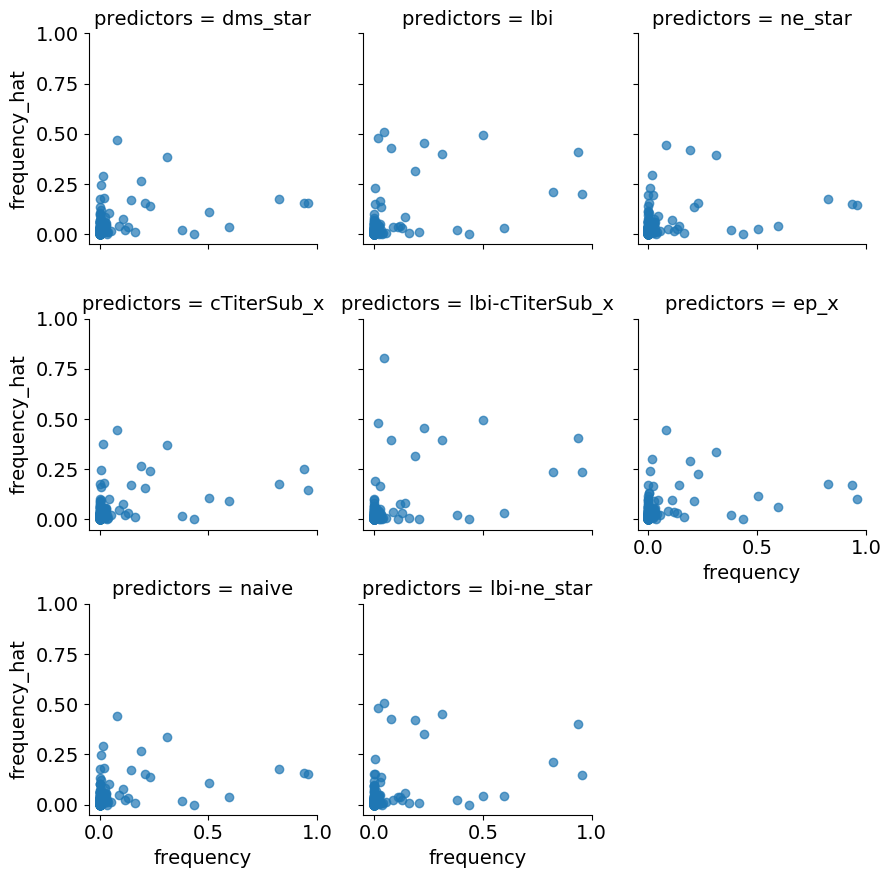

In [186]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=3)
g.map(plt.plot, "frequency", "frequency_hat", marker="o", linestyle="", alpha=0.7)

for ax in g.axes.flatten():
    ax.set_xlim(-0.05, 1)
    ax.set_ylim(-0.05, 1)

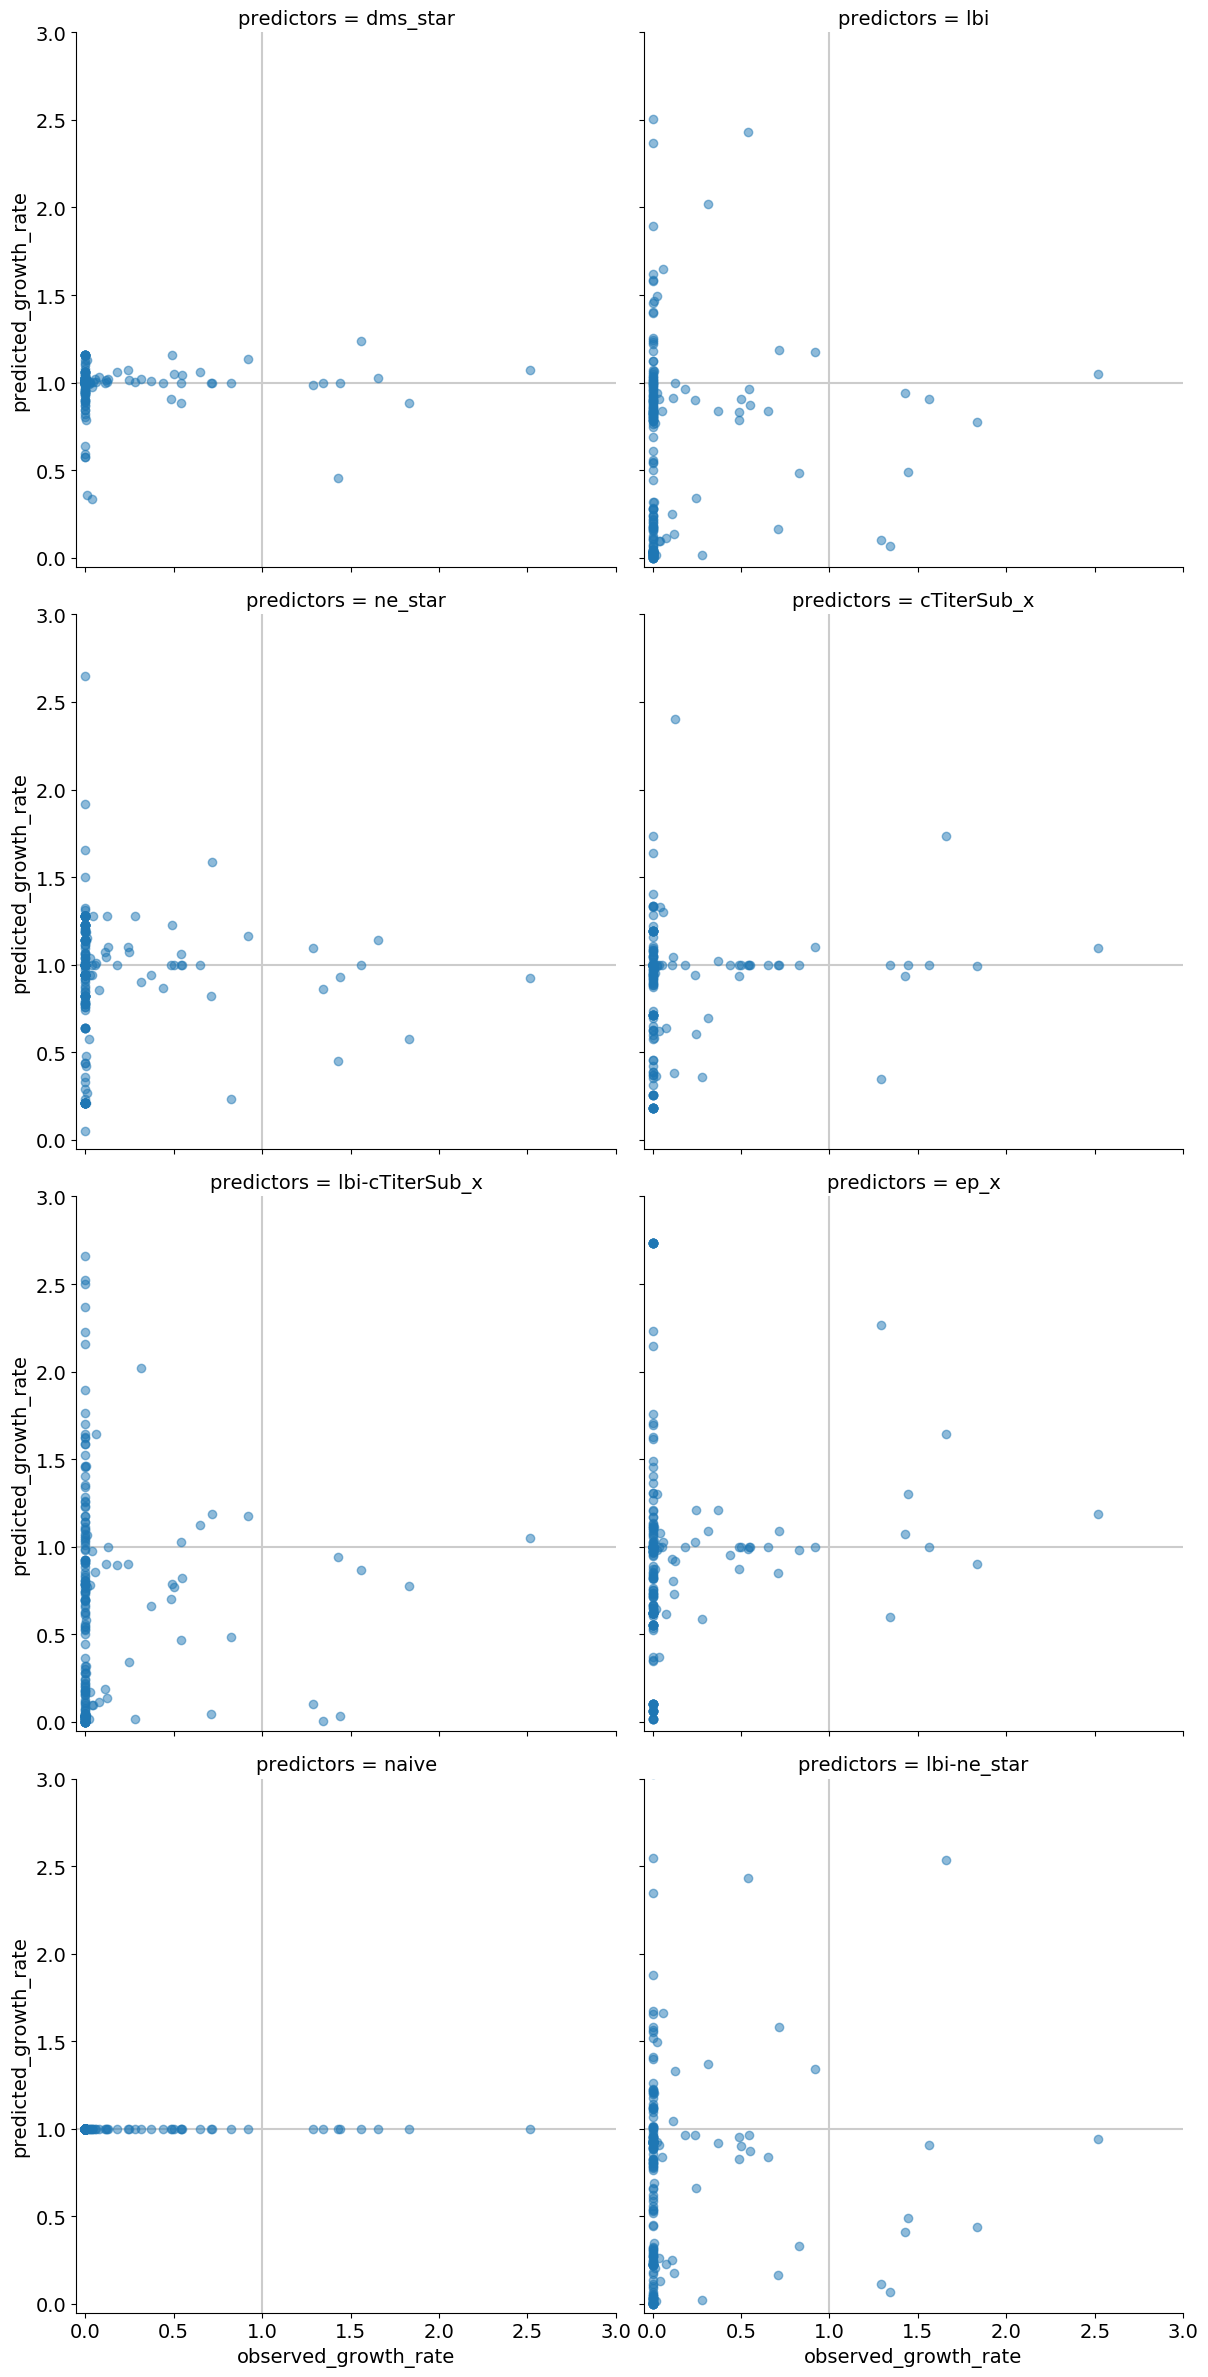

In [187]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "observed_growth_rate", "predicted_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 3)
    ax.set_ylim(-0.05, 3)

In [188]:
mae_df = frequency_df.groupby("predictors").apply(
    lambda group_df: mean_absolute_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mae"})

In [189]:
mae_df.sort_values("mae")

,predictors,mae
4,lbi-cTiterSub_x,0.038075
3,lbi,0.038516
0,cTiterSub_x,0.041065
2,ep_x,0.042220
6,naive,0.043094
1,dms_star,0.043174
5,lbi-ne_star,0.043563
7,ne_star,0.045369


In [190]:
mae_by_timepoint_df = frequency_df.groupby(["predictors", "validation_timepoint"]).apply(
    lambda group_df: mean_absolute_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mae"})

In [191]:
mae_by_timepoint_df.head()

,predictors,validation_timepoint,mae
0,cTiterSub_x,2011-10-01,0.037228
1,cTiterSub_x,2012-04-01,0.045170
2,cTiterSub_x,2012-10-01,0.049984
3,cTiterSub_x,2013-04-01,0.032191
4,cTiterSub_x,2013-10-01,0.044216


In [192]:
naive_mae = mae_by_timepoint_df[mae_by_timepoint_df["predictors"] == "naive"]["mae"].values
for predictor in mae_by_timepoint_df["predictors"].drop_duplicates().values:
    mae_by_timepoint_df.loc[mae_by_timepoint_df["predictors"] == predictor, "adjusted_mae"] =  mae_by_timepoint_df.loc[mae_by_timepoint_df["predictors"] == predictor, "mae"] - naive_mae

In [193]:
mae_df["adjusted_mae"] = mae_df["mae"] - mae_df[mae_df["predictors"] == "naive"]["mae"].iloc[0]

(0, 0.046394583614680594)

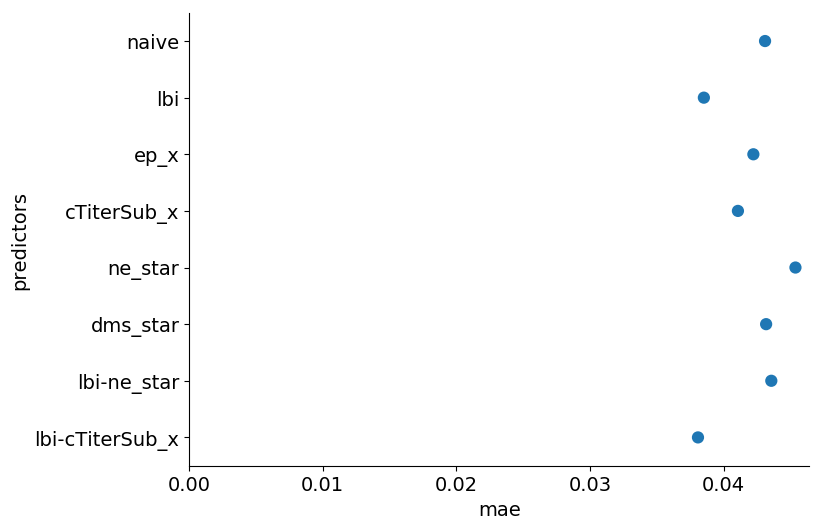

In [194]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="mae",
    y="predictors",
    data=mae_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.set_xlim(left=0)

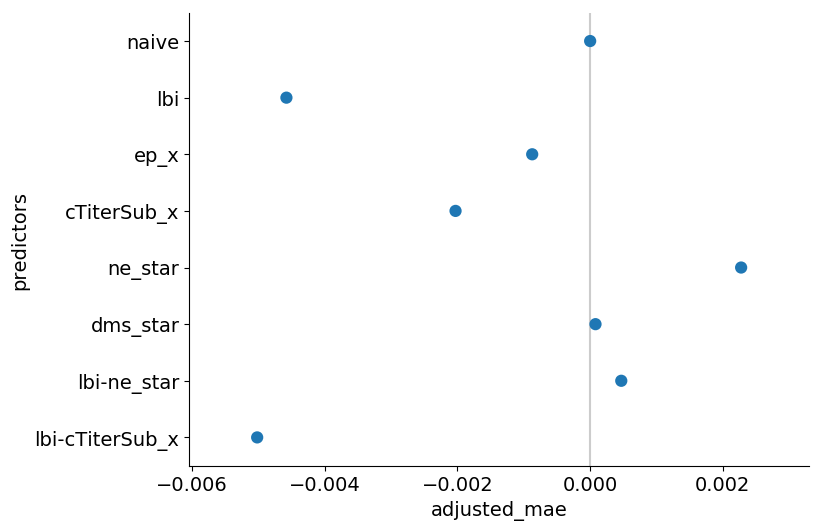

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="adjusted_mae",
    y="predictors",
    data=mae_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.axvline(x=0.0, color="#cccccc", zorder=-10)
#ax.set_xlim(left=0)

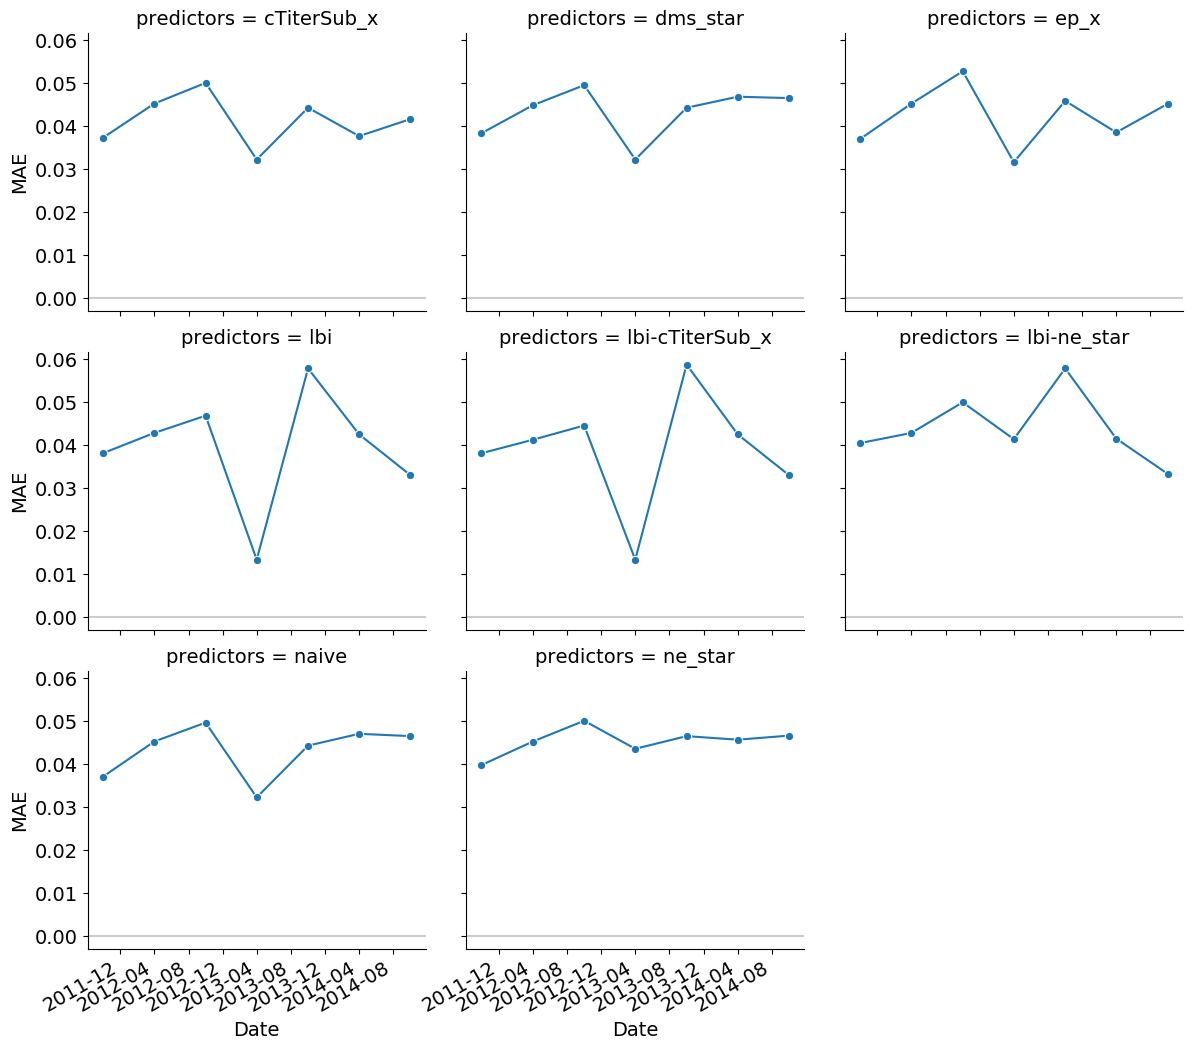

In [196]:
g = facet_time_plot(mae_by_timepoint_df, "mae", "MAE", timepoint_column="validation_timepoint")

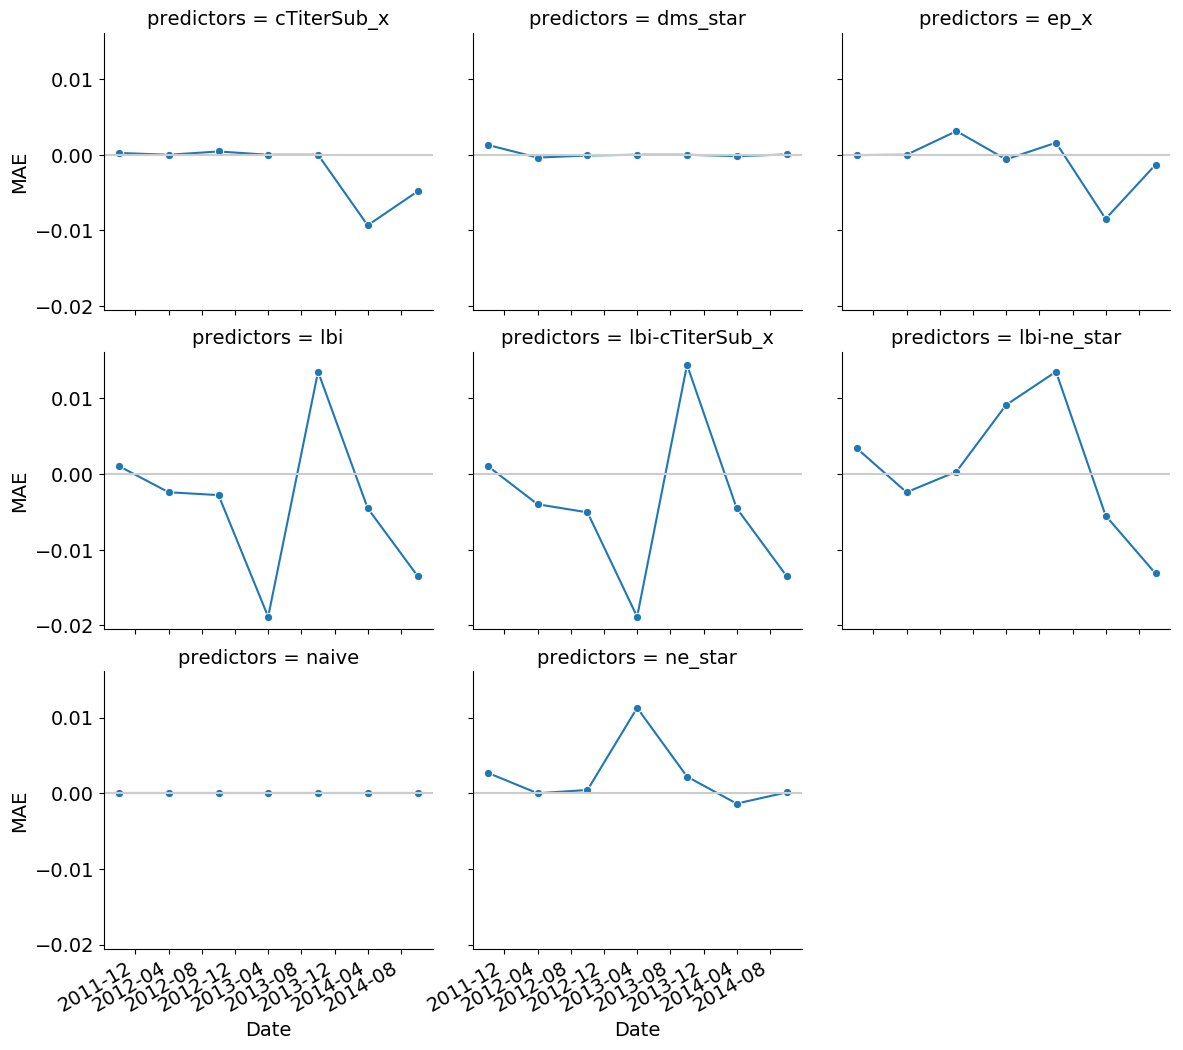

In [197]:
g = facet_time_plot(mae_by_timepoint_df, "adjusted_mae", "MAE", timepoint_column="validation_timepoint")

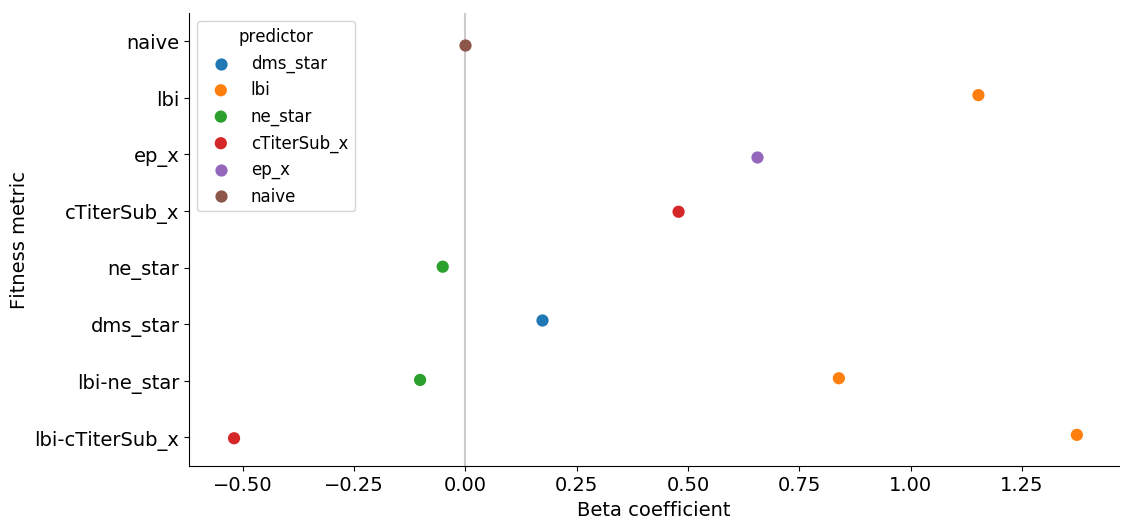

In [198]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.pointplot(
    y="predictors",
    x="mean",
    hue="predictor",
    data=overall_coefficients_df,
    ax=ax,
    dodge=True,
    join=False,
    order=predictor_names_order
)

ax.axvline(0, color="#999999", alpha=0.5, zorder=-10)
ax.set_xlabel("Beta coefficient")
ax.set_ylabel("Fitness metric")

sns.despine()